# Part1 - Data Wrangling

### Imports

In [4]:
import numpy as np 
import pandas as pd
import os

# import sys
# import boto
# from boto.s3.key import Key
# import zipfile
# import boto.s3.connection
# from os.path import basename
# color = sns.color_palette()
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import preprocessing, neighbors

In [252]:
details_2016 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/properties_2016.csv',low_memory=False)
details_2017 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/properties_2017.csv',low_memory=False)
trans_2016 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/train_2016_v2.csv',low_memory=False)
trans_2017 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/train_2017.csv',low_memory=False)

In [253]:
def messingDataCount(yeardf):
    missing_data = yeardf.isnull().sum().to_frame(name='Missing_Count').reset_index()
    missing_data['Missing_percent'] = (missing_data['Missing_Count']/yeardf.shape[0])*100
    missing_data.head()
    missing_data = missing_data.sort_values(by='Missing_percent', axis=0, ascending=True)
    features = missing_data['index'][(missing_data.Missing_percent <30)]
    return features

In [254]:
features = messingDataCount(details_2016)
# Including on the features in the merge data
details_2016_gf = details_2016[features]

In [255]:
# Separating the year and month from the transactiondate column
def transactionColumnSeperation(transactiondf):
    transactiondf['transactiondate'] = pd.to_datetime(transactiondf['transactiondate'])
    transactiondf['year'] = transactiondf['transactiondate'].dt.year
    transactiondf['month'] = transactiondf['transactiondate'].dt.month

In [256]:
transactionColumnSeperation(trans_2016)

In [257]:
merge_2016 = pd.merge(trans_2016,details_2016_gf,on='parcelid')

In [259]:
features = messingDataCount(details_2017)
# Including on the features in the merge data
details_2017_gf = details_2017[features]

In [261]:
transactionColumnSeperation(trans_2017)

In [262]:
merge_2017 = pd.merge(trans_2017,details_2017_gf,on='parcelid')

# Dealing with redundant columns

In [264]:
def deleteRedundantColumns(specificYear):
    # Missing rows in the columns
    specificYear[['bathroomcnt','fullbathcnt','calculatedbathnbr']].isnull().sum().sort_values()
    del specificYear['fullbathcnt']
    del specificYear['calculatedbathnbr']

In [265]:
deleteRedundantColumns(merge_2016)
deleteRedundantColumns(merge_2017)

# 'calculatedfinishedsquarefeet' and 'finishedsquarefeet12' are the same meaning columns

In [266]:
# Missing rows in the columns
def finishedSquarefeet(spYear):
    spYear[['calculatedfinishedsquarefeet','finishedsquarefeet12']].isnull().sum().sort_values()
    #Dropping column 'finishedsquarefeet12'
    del spYear['finishedsquarefeet12']


In [267]:
finishedSquarefeet(merge_2016)
finishedSquarefeet(merge_2017)

# Removing nan Latitude and longitude (minimal nan values)

In [268]:
#merge_2016.dropna(subset=['latitude'])
merge_2017 = merge_2017.dropna(subset=['latitude'])

# filling the missing data in 'heatingorsystemtypeid' column

In [269]:
def heavingSystemMissingData(specYear):
    heat = specYear[['parcelid','yearbuilt','heatingorsystemtypeid']]
    # The system used the most 
    Mode = specYear['heatingorsystemtypeid'].mode()[0]

    year = list(specYear['yearbuilt'].unique())
    heat_system= {}
    for y in year:
        temp = heat[heat.yearbuilt== y]
        #sys = temp["heatingorsystemtypeid"][(temp['count']==m)].values[0]
        #heat_system[y]= sys
        #temp['heatingorsystemtypeid']=temp['heatingorsystemtypeid'].replace(['nan'], m
        if(temp.shape == temp[temp.isnull().any(axis=1)].shape ):
            temp['heatingorsystemtypeid'].fillna(Mode, inplace=True)
        else:
            m = temp['heatingorsystemtypeid'].mode()[0]
            temp['heatingorsystemtypeid'].fillna(m, inplace=True)
        heat.loc[heat.parcelid.isin(temp.parcelid), ['heatingorsystemtypeid']] = temp[['heatingorsystemtypeid']]
    heat['heatingorsystemtypeid'].fillna(heat['heatingorsystemtypeid'].mode()[0], inplace = True)      
    specYear.loc[specYear.parcelid.isin(heat.parcelid), ['heatingorsystemtypeid']] = heat[['heatingorsystemtypeid']]

In [270]:
#heavingSystemMissingData(merge_2016)
#heavingSystemMissingData(merge_2017)

In [271]:
#merge_2016['heatingorsystemtypeid'].fillna(merge_2016['heatingorsystemtypeid'].mode()[0],  inplace=True)

# Catagorical Data

## Mising Data

In [272]:
def propertyCountylandCodeFillNAN (sampleDf):
    #This is for the propertycountylandusecode column and it replaces all the nan with the mode of the column
    sampleDf['propertycountylandusecode'] = sampleDf['propertycountylandusecode'].apply(lambda x: np.nan if x == 0 else x) #and type(x) is not object else x)    # for a column in train_df, change any zero values to Nan
    sampleDf['propertycountylandusecode'] = sampleDf['propertycountylandusecode'].fillna(sampleDf['propertycountylandusecode'].mode()[0]) #fill Nan values with mode values

In [273]:
propertyCountylandCodeFillNAN (merge_2016)
propertyCountylandCodeFillNAN (merge_2017)

In [275]:
def propertyzoningdescNanValues(dataFrame):
    #Creating another dataframe from the main 2017 merged dataframe to just have these three columns
    propertyLandUseCodedf = dataFrame[['parcelid','propertycountylandusecode', 'propertyzoningdesc']]
    #Finding the mode of the propertyzoningdesc column
    propMode = propertyLandUseCodedf['propertyzoningdesc'].mode()[0]

    #Looping through each unique code od the propertycountylandusecode
    for code in list(propertyLandUseCodedf['propertycountylandusecode'].unique()):
        #For each code that comes in I am creating another dataframe that contains al the rows with just these propertyCounty codes
        tempdf = propertyLandUseCodedf.loc[propertyLandUseCodedf['propertycountylandusecode'] == code]
        #First validating that if all the rows in this tempdf has null then I will replace the nan with the overall mode from propMode
        if(tempdf.shape == tempdf[tempdf.isnull().any(axis=1)].shape ):
            tempdf['propertyzoningdesc'].fillna(propMode, inplace=True)
        #If this is not the case then I am finding the mode of the tempdf during each loop and replacing na with the mode
        else:
            themode = tempdf['propertyzoningdesc'].mode()[0]
            tempdf['propertyzoningdesc'].fillna(themode, inplace=True)
        #After each loop I am replacing all the values in the propertyLandUseCodedf with the vales from tempdf based on the parcelid
        propertyLandUseCodedf.loc[propertyLandUseCodedf.parcelid.isin(tempdf.parcelid), ['propertyzoningdesc']] = tempdf[['propertyzoningdesc']]
    #here I am replacing the whole column in main df with the propertyLandUseCodedf based on parcelid
    dataFrame.loc[dataFrame.parcelid.isin(propertyLandUseCodedf.parcelid), ['propertyzoningdesc']] = propertyLandUseCodedf[['propertyzoningdesc']]

In [276]:
# propertyzoningdescNanValues(merge_2016)
# propertyzoningdescNanValues(merge_2017)

## Dummy Variables Replacement

In [277]:
def replaceStrWithDummyVar (maindf):
    lb_make = LabelEncoder()
    maindf["propertycountylandusecode"] = lb_make.fit_transform(maindf["propertycountylandusecode"])
    maindf[["propertycountylandusecode"]]
    lb_makeDesc = LabelEncoder()
    #maindf["propertyzoningdesc"] = lb_makeDesc.fit_transform(maindf["propertyzoningdesc"])
    #maindf[["propertyzoningdesc"]]
    lb_makeDesc = LabelEncoder()
    maindf["transactiondate"] = lb_makeDesc.fit_transform(maindf["transactiondate"])
    maindf[["transactiondate"]]

In [278]:
replaceStrWithDummyVar(merge_2016)
replaceStrWithDummyVar(merge_2017)

# KNN 

## 'yearbuilt'

In [279]:
# 'yearbuilt' column

#def yearbuilt(y):
whole = ['latitude','longitude','yearbuilt','parcelid']
base = ['latitude','longitude']#,'parcelid'
target_column = 'yearbuilt'

null = merge_2016[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2016.loc[not_null, whole].sample(frac = 1)

X_train.latitude.astype(int)
X_train.longitude.astype(int)
X_train.yearbuilt.astype(int)
X=X_train[base].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2016.loc[null, whole].sample(frac = 1)
Y_target.latitude.astype(int)
Y_target.longitude.astype(int)

Y =Y_target[['latitude','longitude']].values

clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy) #this works fine

#Y = Y.reshape(len(X), -1)
prediction = clf.predict(Y)

0.589517309175


In [280]:
Y_target.loc[Y_target.yearbuilt.isnull(),'yearbuilt'] = prediction
merge_2016.loc[merge_2016.parcelid.isin(Y_target.parcelid), ['yearbuilt']] = Y_target[['yearbuilt']]

In [283]:
merge_2016[['calculatedfinishedsquarefeet']].isnull().sum()

calculatedfinishedsquarefeet    0
dtype: int64

## KNN calculatedfinishedsquarefeet

In [282]:
base = 'roomcnt','bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','parcelid'
target_column = 'calculatedfinishedsquarefeet'

null = merge_2016[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2016.loc[not_null, base].sample(frac = 1)

X_train.roomcnt.astype(int)
X_train.bedroomcnt.astype(int)
X_train.bathroomcnt.astype(int)
X_train.calculatedfinishedsquarefeet.astype(int)
X=X_train[['roomcnt','bedroomcnt','bathroomcnt']].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2016.loc[null, base].sample(frac = 1)
Y_target.roomcnt.astype(int)
Y_target.bedroomcnt.astype(int)
Y_target.bathroomcnt.astype(int)

Y =Y_target[['roomcnt','bedroomcnt','bathroomcnt']].values

clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy) #this works fine

#Y = Y.reshape(len(X), -1)
prediction = clf.predict(Y)
prediction[0]

Y_target.loc[Y_target.calculatedfinishedsquarefeet.isnull(),'calculatedfinishedsquarefeet'] = prediction
merge_2016.loc[merge_2016.parcelid.isin(Y_target.parcelid), ['calculatedfinishedsquarefeet']] = Y_target[['calculatedfinishedsquarefeet']]

0.00707478742161


# Additional columns

In [284]:
def ageColumn(yeardataf):
    yeardataf['age'] =2017-yeardataf['yearbuilt']

In [285]:
ageColumn(merge_2016)
ageColumn(merge_2017)

# Concatinating the 2016 and 2017 dataframes

In [286]:
df_concat = pd.concat([merge_2016, merge_2017])

# Reading file into CSV

In [287]:
directory = os.path.dirname(os.getcwd()) 
cur_path = directory+'\\Assignment2'
cur_path
df_concat.to_csv('zillowData.csv', sep=',')

# Uploading csv to AWS

In [37]:
AWS_ACCESS_KEY_ID=''
AWS_SECRET_ACCESS_KEY=''
try:
    connect = boto.connect_s3(AWS_ACCESS_KEY_ID,AWS_SECRET_ACCESS_KEY)

except:
    print("incorrect aws access key and/or secret key")

In [38]:
#connection = boto.connect_s3(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

#csvFile = 'zillowData.csv'
zipname = "zillowdata.zip"
z = zipfile.ZipFile(zipname, "w")
z.write('zillowData.csv')
cur_path
bucket_name = 'zillowdatampsc'



loc = boto.s3.connection.Location.USWest

bucket = connect.create_bucket(bucket_name, location=loc)
def percent_cb(complete, total):
    sys.stdout.write('.')
    sys.stdout.flush()

s3key = boto.s3.key.Key(bucket)
s3key.key = zipname
s3key.set_contents_from_filename(zipname, cb=percent_cb, num_cb=10)

.......

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [288]:
m_16 = merge_2016[merge_2016.regionidzip.notnull() & 
           merge_2016.taxamount.notnull() & 
           merge_2016.taxvaluedollarcnt.notnull() & 
           merge_2016.structuretaxvaluedollarcnt.notnull() &
           merge_2016.regionidcity.notnull() &  
           merge_2016.landtaxvaluedollarcnt.notnull() &
           merge_2016.regionidcity.notnull()& 
           merge_2016.censustractandblock.notnull() & merge_2016.lotsizesquarefeet.notnull()]
           

In [289]:
m_17 = merge_2017[merge_2017.regionidzip.notnull() & 
           merge_2017.taxamount.notnull() & 
           merge_2017.taxvaluedollarcnt.notnull() & 
           merge_2017.structuretaxvaluedollarcnt.notnull() &
           merge_2017.regionidcity.notnull() &  
           merge_2017.landtaxvaluedollarcnt.notnull() &
           merge_2017.regionidcity.notnull()& 
           merge_2017.censustractandblock.notnull() & merge_2017.lotsizesquarefeet.notnull()]

In [290]:
df_concat = pd.concat([m_16, m_17])
df_concat.to_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/Concat.csv', sep=',')

In [44]:
m_16.to_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/m_16.csv', sep=',')
m_17.to_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/m_17.csv', sep=',')

In [291]:
merge_2016.isnull().sum().sort_values()

parcelid                            0
yearbuilt                           0
calculatedfinishedsquarefeet        0
propertycountylandusecode           0
roomcnt                             0
bedroomcnt                          0
assessmentyear                      0
latitude                            0
longitude                           0
bathroomcnt                         0
rawcensustractandblock              0
logerror                            0
transactiondate                     0
regionidcounty                      0
year                                0
age                                 0
fips                                0
propertylandusetypeid               0
month                               0
landtaxvaluedollarcnt               1
taxvaluedollarcnt                   1
taxamount                           6
regionidzip                        35
structuretaxvaluedollarcnt        380
censustractandblock               605
regionidcity                     1803
lotsizesquar

## 'taxvaluedollarcnt' 'taxamount' and 'landtaxvaluedollarcnt' 

In [292]:
merge_2016[['taxvaluedollarcnt','landtaxvaluedollarcnt']].isnull().sum()

taxvaluedollarcnt        1
landtaxvaluedollarcnt    1
dtype: int64

In [293]:
merge_2016[['taxvaluedollarcnt','landtaxvaluedollarcnt','assessmentyear']][merge_2016.taxvaluedollarcnt.isnull()]

,taxvaluedollarcnt,landtaxvaluedollarcnt,assessmentyear
68986,NaN,NaN,2015.0


In [294]:
merge_2016['taxvaluedollarcnt'].fillna((merge_2016['taxvaluedollarcnt'].mean()), inplace=True)
merge_2016['landtaxvaluedollarcnt'].fillna((merge_2016['landtaxvaluedollarcnt'].mean()), inplace=True)
merge_2016['taxamount'].fillna((merge_2016['taxamount'].mean()), inplace=True)

In [295]:
merge_2016.isnull().sum().sort_values()

parcelid                            0
landtaxvaluedollarcnt               0
yearbuilt                           0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
taxamount                           0
propertycountylandusecode           0
roomcnt                             0
bedroomcnt                          0
assessmentyear                      0
bathroomcnt                         0
longitude                           0
regionidcounty                      0
rawcensustractandblock              0
propertylandusetypeid               0
fips                                0
month                               0
year                                0
transactiondate                     0
logerror                            0
latitude                            0
age                                 0
regionidzip                        35
structuretaxvaluedollarcnt        380
censustractandblock               605
regionidcity                     1803
lotsizesquar

In [139]:
# x, y = pd.Series(merge_2016.taxvaluedollarcnt, name="x_var"), pd.Series(merge_2016.landtaxvaluedollarcnt, name="y_var")
# ax = sns.regplot(x=x, y=y, marker="+")
# plt.show()

In [89]:
# fig,ax1= plt.subplots()
# fig.set_size_inches(20,10)
# merge_2016["regionidcounty"] = merge_2016["regionidcounty"].map(lambda x:str(x).split(".")[0])
# yearMerged = merge_2016.groupby(['regionidcounty', 'regionidzip'])["parcelid"].count().unstack('regionidzip').fillna(0)
# yearMerged.plot(kind='bar', stacked=False,ax=ax1)

# ax1.set_xlabel('Different County in California',fontsize=20, color='red')
# ax1.set_ylabel('Count of house',fontsize=14, color='red')
# plt.show()

In [223]:
#merge_2016[['regionidcounty','parcelid', 'regionidcity']][merge_2016.regionidzip.isnull()].sort_values(by='regionidcounty')

In [152]:
merge_2016[['regionidcounty','parcelid', 'regionidcity','regionidzip']][merge_2016.regionidzip.isnull()].groupby(merge_2016.regionidcounty).count()

,regionidcounty,parcelid,regionidcity,regionidzip
regionidcounty,,,,
1286.0,6,6,3,0
2061.0,29,29,11,0


### 'regionidcity'

In [296]:
def missingcity(m):
    city = m[['regionidcounty','parcelid', 'regionidcity']]
    Mode = m['regionidcity'].mode()[0]
    county= list(city['regionidcounty'].unique())

    for c in county:
        temp = city[city.regionidcounty == c]
        if(temp.shape == temp[temp.isnull().any(axis=1)].shape ):
                temp['regionidcity'].fillna(Mode, inplace=True)
        else:
                c = temp['regionidcity'].mode()[0]
                temp['regionidcity'].fillna(c, inplace=True)
        city.loc[city.parcelid.isin(temp.parcelid), ['regionidcity']] = temp[['regionidcity']]
    city['regionidcity'].fillna(city['regionidcity'].mode()[0], inplace = True)      
    m.loc[m.parcelid.isin(city.parcelid), ['regionidcity']] = city[['regionidcity']]

In [298]:
missingcity(merge_2016)

/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### regionidzip

In [406]:
def missingzipcode(m):
    city = m[['regionidcity','parcelid', 'regionidzip']]
    Mode = m['regionidzip'].mode()[0]
    county= list(city['regionidcity'].unique())

    for c in county:
        temp = city[city.regionidcity == c]
        if( temp.regionidzip.isnull().sum()==0):
            break
        else:
            if(temp.shape == temp[temp.isnull().any(axis=1)].shape ):
                temp['regionidzip'].fillna(Mode, inplace=True)
            else:
                c = temp['regionidzip'].mode()[0]
                temp['regionidzip'].fillna(c, inplace=True)
            city.loc[city.parcelid.isin(temp.parcelid), ['regionidzip']] = temp[['regionidzip']]
    city['regionidzip'].fillna(city['regionidzip'].mode()[0], inplace = True)      
    m.loc[m.parcelid.isin(city.parcelid), ['regionidzip']] = city[['regionidzip']]

In [408]:
missingzipcode(merge_2016)

/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [409]:
merge_2016.regionidzip.isnull().sum()

0

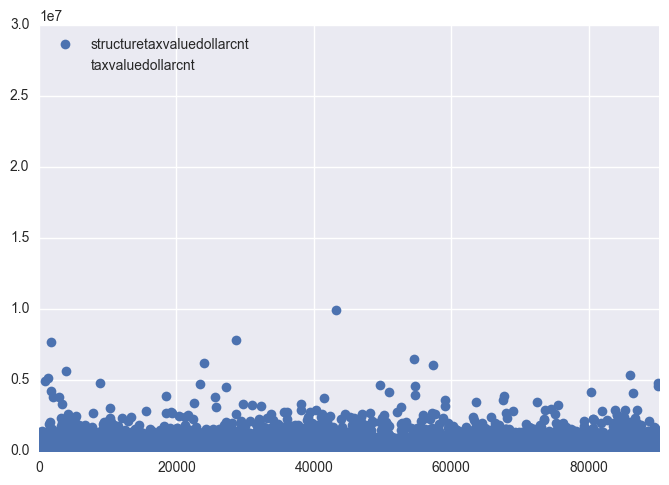

In [205]:
merge_2016[['structuretaxvaluedollarcnt','taxvaluedollarcnt']].plot(style=['o','x'])
plt.show()

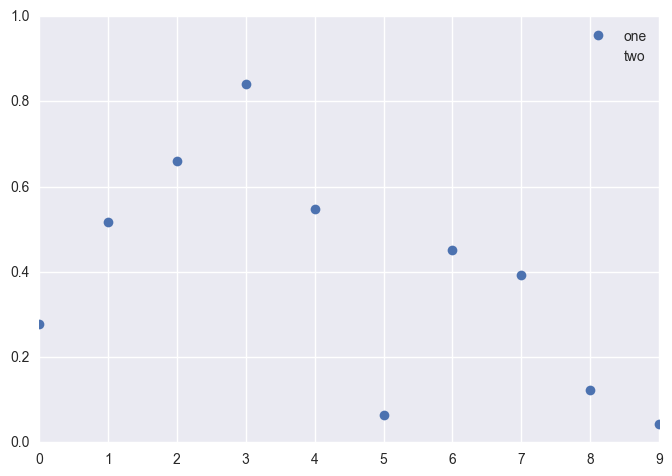

In [211]:
import numpy as np
import pandas as pd

d = {'one' : np.random.rand(10),
     'two' : np.random.rand(10)}

df = pd.DataFrame(d)

df.plot(style=['o','x'])
plt.show()

In [221]:
# colors = np.where(merge_2016,'taxvaluedollarcnt','structuretaxvaluedollarcnt',)
# #plt.scatter(merge_2016.taxvaluedollarcnt, merge_2016.structuretaxvaluedollarcnt, s=120, c=colors)
# # OR (with pandas 0.13 and up)
# merge_2016.plot(kind='scatter', x='taxvaluedollarcnt', y='structuretaxvaluedollarcnt', s=120, c=colors)

In [227]:
# import seaborn as sns
# sns.set()

# # Load the example tips dataset
# #iris = sns.load_dataset("iris")

# # Plot tip as a function of toal bill across days
# g = sns.lmplot(x="taxamount", y="structuretaxvaluedollarcnt", hue="parcelid",
#                truncate=True, size=5, data=merge_2016)

# # Use more informative axis labels than are provided by default
# g.set_axis_labels("Sepal length (mm)", "Sepal width (mm)")

## 'censustractandblock'

In [324]:
base = 'roomcnt','parcelid','censustractandblock'
target_column = 'censustractandblock'

null = merge_2016[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2016.loc[not_null, base].sample(frac = 1)

X_train.roomcnt.astype(int)
# X_train.bedroomcnt.astype(int)
# X_train.bathroomcnt.astype(int)
# X_train.calculatedfinishedsquarefeet.astype(int)
X=X_train[['roomcnt','parcelid']].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2016.loc[null, base].sample(frac = 1)
Y_target.roomcnt.astype(int)
# Y_target.bedroomcnt.astype(int)
# Y_target.bathroomcnt.astype(int)

Y =Y_target[['roomcnt','parcelid']].values

clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy) #this works fine

#Y = Y.reshape(len(X), -1)
prediction = clf.predict(Y)
prediction[0]

Y_target.loc[Y_target.censustractandblock.isnull(),'censustractandblock'] = prediction
merge_2016.loc[merge_2016.parcelid.isin(Y_target.parcelid), ['censustractandblock']] = Y_target[['censustractandblock']]

0.592260510762


In [410]:
merge_2016.isnull().sum()

parcelid                            0
logerror                            0
transactiondate                     0
year                                0
month                               0
fips                                0
propertylandusetypeid               0
rawcensustractandblock              0
regionidcounty                      0
longitude                           0
latitude                            0
assessmentyear                      0
bedroomcnt                          0
bathroomcnt                         0
roomcnt                             0
propertycountylandusecode           0
regionidzip                         0
taxamount                           0
taxvaluedollarcnt                   0
structuretaxvaluedollarcnt          0
calculatedfinishedsquarefeet        0
yearbuilt                           0
regionidcity                        0
landtaxvaluedollarcnt               0
censustractandblock                 0
lotsizesquarefeet               10150
age         

### structuretaxvaluedollarcnt

In [347]:
# base = 'roomcnt','parcelid','structuretaxvaluedollarcnt','calculatedfinishedsquarefeet','taxamount','taxvaluedollarcnt','landtaxvaluedollarcnt'
base = 'roomcnt','parcelid','structuretaxvaluedollarcnt','taxamount','taxvaluedollarcnt'
target_column = 'structuretaxvaluedollarcnt'

null = merge_2016[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2016.loc[not_null, base].sample(frac = 1)

X_train.roomcnt.astype(int)
X_train.structuretaxvaluedollarcnt.astype(int)
# X_train.calculatedfinishedsquarefeet.astype(int)
X_train.taxamount.astype(int)
X_train.taxvaluedollarcnt.astype(int)
# X_train.landtaxvaluedollarcnt.astype(int)
X=X_train[['roomcnt','parcelid','taxamount','taxvaluedollarcnt']].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2016.loc[null, base].sample(frac = 1)
Y_target.roomcnt.astype(int)
#Y_target.structuretaxvaluedollarcnt.astype(int)
# Y_target.calculatedfinishedsquarefeet.astype(int)
Y_target.taxamount.astype(int)
Y_target.taxvaluedollarcnt.astype(int)
# Y_target.landtaxvaluedollarcnt.astype(int)
Y =Y_target[['roomcnt','parcelid','taxamount','taxvaluedollarcnt']].values

0.205261694199


In [363]:
clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy)
prediction = clf.predict(Y)

Y_target.loc[Y_target.structuretaxvaluedollarcnt.isnull(),'structuretaxvaluedollarcnt'] = prediction
merge_2016.loc[merge_2016.parcelid.isin(Y_target.parcelid), ['structuretaxvaluedollarcnt']] = Y_target[['structuretaxvaluedollarcnt']]

0.205261694199


### Lotsize

In [411]:
base = 'bathroomcnt','parcelid','structuretaxvaluedollarcnt','lotsizesquarefeet'
target_column = 'lotsizesquarefeet'

null = merge_2016[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2016.loc[not_null, base].sample(frac = 1)

X_train.bathroomcnt.astype(int)
X_train.structuretaxvaluedollarcnt.astype(int)

X=X_train[['bathroomcnt','parcelid','structuretaxvaluedollarcnt']].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2016.loc[null, base].sample(frac = 1)

Y_target.bathroomcnt.astype(int)
Y =Y_target[['bathroomcnt','parcelid','structuretaxvaluedollarcnt']].values

In [412]:
clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy)
prediction = clf.predict(Y)

0.232399375975


In [413]:
Y_target.loc[Y_target.lotsizesquarefeet.isnull(),'lotsizesquarefeet'] = prediction
merge_2016.loc[merge_2016.parcelid.isin(Y_target.parcelid), ['lotsizesquarefeet']] = Y_target[['lotsizesquarefeet']]

In [414]:
merge_2016.isnull().sum()

parcelid                        0
logerror                        0
transactiondate                 0
year                            0
month                           0
fips                            0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcounty                  0
longitude                       0
latitude                        0
assessmentyear                  0
bedroomcnt                      0
bathroomcnt                     0
roomcnt                         0
propertycountylandusecode       0
regionidzip                     0
taxamount                       0
taxvaluedollarcnt               0
structuretaxvaluedollarcnt      0
calculatedfinishedsquarefeet    0
yearbuilt                       0
regionidcity                    0
landtaxvaluedollarcnt           0
censustractandblock             0
lotsizesquarefeet               0
age                             0
dtype: int64

In [ ]:
#m_16.to_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/m_17.csv', sep=',')